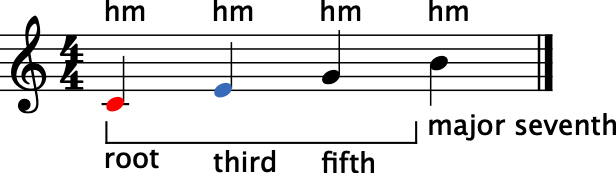

In [1]:
from music21 import *

s = stream.Score()

part = stream.Part()

notes = [
    ("C4", "root"),
    ("E4", "third"),
    ("G4", "fifth"),
    ("B4", "major seventh")
]

for p, a in notes:
    n = note.Note(p, quarterLength=1)

    if p == "C4":
        n.style.color = "red"
    
    if p == "E4":
        n.style.color = "#386aba"
    
    te1 = expressions.TextExpression(a)
    te1.style.justify = "center"
    te1.style.fontSize = 10
    te1.style.fontFamily = "Segoe UI"
    te1.placement = "below"
    part.append(te1)

    te2 = expressions.TextExpression("hm")
    te2.style.fontSize = 10
    te2.style.fontFamily = "Segoe UI"
    te2.placement = "above"
    part.append(te2)

    part.append(n)

cnote = part.recurse().notes[0]
enote = part.recurse().notes[2]
spn = spanner.Line([cnote, enote])
spn.lineType = "solid"
spn.placement = "below"
spn.tick = "up"
part.insert(0.0, spn)

s.append(part)

s.show()

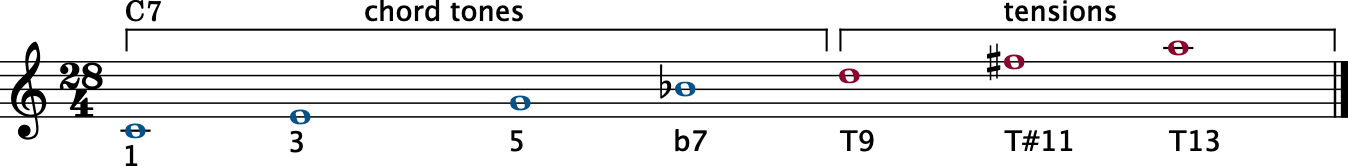

In [2]:
from music21 import *

s = stream.Score()

part = stream.Part()

part.append(meter.TimeSignature("28/4"))

c7_chord = harmony.ChordSymbol("C7")
c7_chord.style.fontFamily = "Segoe UI"

part.append(c7_chord)

notes = [
    ("C4", "1"),
    ("E4", "3"),
    ("G4", "5"),
    ("B-4", "b7"),
    ("D5", "T9"),
    ("F#5", "T#11"),
    ("A5", "T13")
]

for p, a in notes:
    n = note.Note(p, quarterLength=4)
    texp = expressions.TextExpression(a)
    texp.style.fontSize = 10
    texp.style.fontFamily = "Segoe UI"
    texp.placement = "below"
    
    if not "T" in a:
        n.style.color = "#06538a"
    else:
        n.style.color = "#8a062d"
    
    part.append(texp)
    
    part.append(n)

tones_start = part.recurse().notes[1]
tones_end = part.recurse().notes[4]
tones_line = spanner.Line([tones_start, tones_end])
tones_line.lineType = "solid"

tones_texp = expressions.TextExpression("chord tones")
tones_texp.style.fontSize = 10
tones_texp.style.fontFamily = "Segoe UI"
tones_texp.placement = "above"

tens_start = part.recurse().notes[5]
tens_end = part.recurse().notes[7]
tens_line = spanner.Line([tens_start, tens_end])
tens_line.lineType = "solid"

tens_texp = expressions.TextExpression("tensions")
tens_texp.style.fontSize = 10
tens_texp.style.fontFamily = "Segoe UI"
tens_texp.placement = "above"

part.insert(1, tones_line)
part.insert(5, tones_texp)
part.insert(6, tens_line)
part.insert(20, tens_texp)

s.append(part)

s.show()

In [109]:
from music21 import *
from IPython.display import Image


def music(notes: str, midi: bool=False):
    s = stream.Score()
    part = stream.Part()
    
    # get info
    info_start = 5
    
    for i in range(info_start, len(notes)):
        if notes[i:i+5] == "INFO ":
            info_end = i
    
    info = list(filter(lambda x: len(x) > 0, notes[info_start:info_end].split(" ")))
    
    # set clef
    if info[0].lower == "treble":
        part.append(clef.TrebleClef())
    elif info[0].lower == "bass":
        part.append(clef.BassClef())
    
    # set key
    keys = [["cb", -7], ["gb", -6], ["db", -5], ["ab", -4], ["eb", -3], ["bb", -2], ["f", -1], ["c", 0], ["g", 1], ["d", 2], ["a", 3], ["e", 4], ["b", 5], ["f#", 6], ["c#", 7]]
    for k in keys:
        if info[1].lower() == k[0]:
            part.append(key.KeySignature(k[1]))
    
    # set time signature
    part.append(meter.TimeSignature(info[2]))
    
    # add notes
    notes = notes[info_end+5:].split(" ")
    add_notes = []
    for n in notes:
        # add chord name
        if n[0] == "!":
            add_notes.append(harmony.ChordSymbol(n[1:]))
        # start next measure on a new line
        elif n == "^":
            add_notes.append(layout.SystemLayout(isNew=True))
        else:
            # set variables
            is_chord, is_tie = False, "none"
            # if the note is a chord
            if "(" in n:
                is_chord = True
                note_name = n.replace("(", "").replace(")", "").split(",")
                if "t" in note_name[-1]:
                    note_length = note_name[-1][-2:]
                    note_name[-1] = note_name[-1][:-2]
                else:
                    note_length = note_name[-1][-1]
                    note_name[-1] = note_name[-1][:-1]
            else:
                if "{" in n:
                    is_tie = "start"
                if "}" in n:
                    is_tie = "stop"
                if n[-1] == "t":
                    note_name = n[:-2].replace("{", "").replace("}", "")
                    note_length = n[-2:]
                else:
                    note_name = n[:-1].replace("{", "").replace("}", "")
                    note_length = n[-1:]
            lengths = [["w", 4], ["h", 2], ["q", 1], ["e", 0.5], ["s", 0.25]]
            for l in lengths:
                if isinstance(note_length, str):
                    if l[0] in note_length:
                        if "t" in note_length:
                            note_length = l[1] * 0.333333333
                        else:
                            note_length = l[1]
            if is_tie == "none":
                add_notes.append([note_name, note_length])
            else:
                add_notes.append([note_name, note_length, is_tie])
    for n in add_notes:
        if isinstance(n, list):
            if isinstance(n[0], list):
                add_n = chord.Chord(n[0], quarterLength=n[1])
            else:
                if n[0].lower() == "r":
                    add_n = note.Rest(quarterLength=n[1])
                elif n[0] in ["slash", "s"]:
                    add_n = note.Unpitched()
                    add_n.notehead = "slash"
                    add_n.stemDirection = "noStem"
                    add_n.volume.velocity = 0
                else:
                    add_n = note.Note(n[0], quarterLength=n[1])
            if len(n) == 3:
                add_n.tie = tie.Tie(n[2])
            part.append(add_n)
        else:
            part.append(n)
    
    s.append(part)
    swung_part = stream.Part()
    
    if midi:
        step = 0.0
        for item in part:
            if isinstance(item, note.Note) or isinstance(item, note.Rest):
                if str(step)[-1] == "9":
                    step = float(round(step))
                elif str(step)[-1] == "2":
                    step = float(round(step))
                if isinstance(item, note.Note):
                    new_note = note.Note(item.pitch)
                    if item.tie:
                        if "start" in str(item.tie):
                            new_note.tie = tie.Tie("start")
                        if "stop" in str(item.tie):
                            new_note.tie = tie.Tie("stop")
                        if "continue" in str(item.tie):
                            new_note.tie = tie.Tie("continue")
                else:
                    new_note = note.Rest()
                if str(step)[-2:] == ".0":
                    if item.quarterLength == 0.5:
                        new_note.quarterLength = (0.333333333 * 2)
                    elif item.quarterLength == 1.5:
                        new_note.quarterLength = 1 + (0.333333333 * 2)
                    elif str(item.quarterLength) == "1/3":
                        new_note.quarterLength = 0.333333333
                    else:
                        new_note.quarterLength = item.quarterLength
                elif str(step)[-2:] == ".5":
                    if item.quarterLength == 0.5:
                        new_note.quarterLength = 0.333333333
                    elif item.quarterLength == 1.5:
                        new_note.quarterLength = 1 + .333333333
                    else:
                        new_note.quarterLength = item.quarterLength
                if str(item.quarterLength) == "1/3":
                    new_note.quarterLength = 0.333333333
                swung_part.append(new_note)
                step += item.quarterLength
            else:
                swung_part.append(item)
        swung_s = stream.Stream()
        guitar = instrument.Guitar()
        swung_s.append(guitar)
        swung_s.append(swung_part)
        return swung_s.show("midi")
    else:
        return Image(filename=s.write("musicxml.png"))

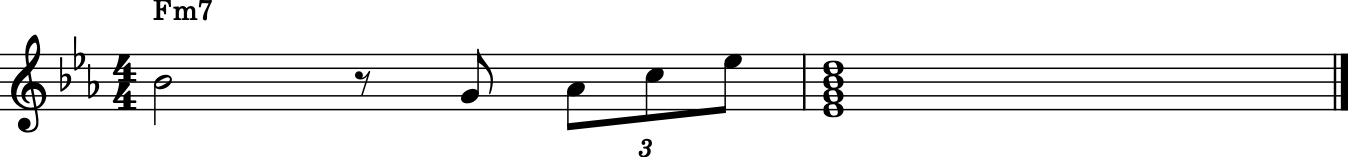

In [110]:
notes = "INFO treble eb 4/4 INFO !fm7 b-4h re g4e a-4qt c5qt e-5qt (e-4,g4,b-4,d5)w"
music(notes, True)
music(notes)

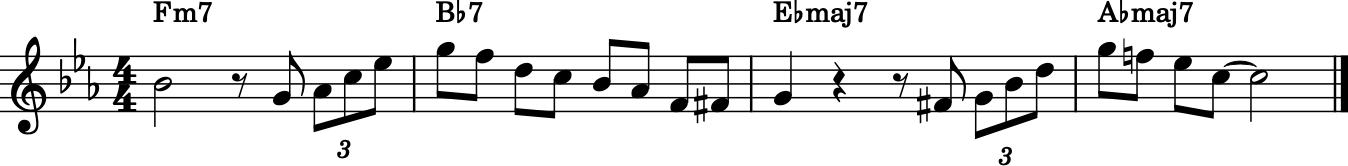

In [114]:
notes = "INFO treble eb 4/4 INFO !fm7 b-4h re g4e a-4qt c5qt e-5qt !b-7 g5e f5e d5e c5e b-4e a-4e f4e f#4e !e-maj7 g4q rq re f#4e g4qt b-4qt d5qt !a-maj7 g5e f5e e-5e c5{e c5}h"
music(notes, True)
music(notes)